# LEI - Análise de Sentimentos




Vamos começar por importar algumas bibliotecas necessarias para a resolução dete projeto.

In [1]:
import os
import pandas as pd
import numpy as np
import random
import re
import nltk 

from nltk import tokenize
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


<h2>Setup</h2>

In [87]:
def plot_cm(y_true, y_pred, figsize=(6,6)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    ax.xaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])
    ax.yaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [88]:
# predictor
X_col = 'tweet_text'
# classifier
y_col = 'sentiment' 

## FASE 1 - Análise e Preparação dos dados

Nesta etapa, vamos importar os dados de treino, analisar a sua distribuição no dataset, procurar pela existencias de valores em falta.

### Load training dataset

In [89]:
train_ds = pd.read_csv('Train3Classes.csv', delimiter=';')

In [90]:
# update classifiers to nominal value
train_ds[y_col] = train_ds[y_col].map({0: 'Negative', 1: 'Positive', 2: 'Neutral'})

In [91]:
train_ds.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,Positive,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,Positive,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,Positive,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,Positive,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,Positive,:)


In [92]:
#Retirar as features id e tweet_date, query_used por não terem qualquer relação com o que pretendemos analisar.

X_train = train_ds.loc[:, X_col].values
y_train = train_ds.loc[:, y_col].values

<h4>Exploratory Analysis</h4>

In [93]:
print("O DataSet de treino possui " + str(len(X_train)) + " entradas!")

O DataSet de treino possui 100000 entradas!


In [94]:
missing = round((train_ds.isnull().sum()/train_ds.isnull().count()).sort_values(ascending=False)*100,2)
missing_info = pd.concat([missing],keys=['Missing values'],axis=1)
missing_info.style.background_gradient()

,Missing values
query_used,0.000000
sentiment,0.000000
tweet_date,0.000000
tweet_text,0.000000
id,0.000000


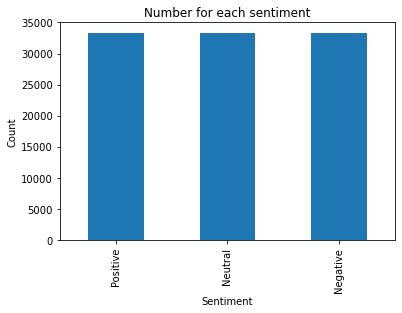

In [95]:
series = train_ds['sentiment'].value_counts()
ax = series.plot(kind='bar', title='Number for each sentiment')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.show()

Do gráfico e tabela anteriores é possivel verificar que o dataset de treino se encontra perfeitamente balanceado e sem valores em falta.

In [96]:
# check data
for i in range(0, 5):
    print(y_train[i], ' => ', X_train[i])


Positive  =>  @Laranjito76 A pessoa certa para isso seria o vale e azevedo :)
Positive  =>  @behin_d_curtain Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)
Positive  =>  Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina https://t.co/5RjhKnj0oh Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional :D
Positive  =>  aaaaaaaa amei tanto essas polaroids, nem sei expressar o quanto eu to apaixonada de vdd✨💖🎈🎉🎊 espero que outras pessoas consigam ganhar também :) https://t.co/pbIp7tRcSE
Positive  =>  Valoriza o coração do menininho que vc tem. Ele é diferente. O faça sorrir e ter certeza disso ❤️ — Eu valorizo todo mundo na minha vida, não vai ser diferente com ele :)) https://t.co/5c7wlXQyz9


In [97]:
train_ds.tweet_text
train_ds[train_ds['sentiment']=='Positive'].head()
#" ".join(train_ds[train_ds.sentiment == "2"].tweet_text)

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,Positive,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,Positive,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,Positive,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,Positive,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,Positive,:)


### Load test dataset

<h4>Load and prepare X_test, y_test</h4>

In [98]:
test_ds = pd.read_csv('Test3classes.csv', delimiter=';')

In [99]:
missing = test_ds.isna().sum().sort_values(ascending=False)
missing_info = pd.concat([missing],keys=['Missing values'],axis=1)
missing_info.style.background_gradient()

,Missing values
query_used,0
sentiment,0
tweet_date,0
tweet_text,0
id,0


In [100]:
# update classifiers to nominal value
test_ds[y_col] = test_ds[y_col].map({0: 'Negative', 1: 'Positive', 2: 'Neutral'})

In [101]:
#Retirar as features id e tweet_date, query_used por não terem qualquer relação com o que pretendemos analisar.

X_test = test_ds.loc[:, X_col].values
y_test = test_ds.loc[:, y_col].values

In [102]:
print("O DataSet de teste possui " + str(len(X_test)) + " entradas!")

O DataSet de teste possui 4999 entradas!


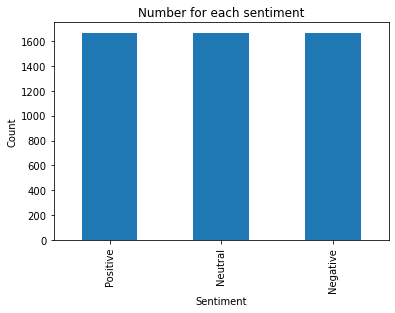

In [103]:
series = test_ds['sentiment'].value_counts()
ax = series.plot(kind='bar', title='Number for each sentiment')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.show()

Do gráfico e tabela anterior é possivel verificar que o dataset de teste se encontra perfeitamente balanceado e sem valores em falta.

## FASE 2 - Processamento dos dados

Um  processamento  de  dados  adequado  irá no  futuro  permitir  obter  uma melhor performance de classificação do modelo. Para isso vamos,  
 - converter todas a palavras para minusculas.
 - retirar carateres especiais, links e hashtags.

Em seguida, aplicou-se tecnicas de processamento de linguegem recorrendo ao modulo NLTK. 


Começamos, por transformar todas as letras das palavras em minusculas.

In [104]:

for i in range(0,len(X_train)):
    X_train[i] = X_train[i].lower()

for i in range(0,len(X_test)):
    X_test[i] = X_test[i].lower()

## Verificar os dados
for i in range(0, 5):
    print(y_train[i], ' => ', X_train[i])
    

Positive  =>  @laranjito76 a pessoa certa para isso seria o vale e azevedo :)
Positive  =>  @behin_d_curtain para mim, é precisamente o contrário :) vem a chuva e vem a boa disposição :)
Positive  =>  vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do csgo e sobre a pagina https://t.co/5rjhknj0oh alguem tem uma sugestao? queria falar sobre algo do cenario nacional :d
Positive  =>  aaaaaaaa amei tanto essas polaroids, nem sei expressar o quanto eu to apaixonada de vdd✨💖🎈🎉🎊 espero que outras pessoas consigam ganhar também :) https://t.co/pbip7trcse
Positive  =>  valoriza o coração do menininho que vc tem. ele é diferente. o faça sorrir e ter certeza disso ❤️ — eu valorizo todo mundo na minha vida, não vai ser diferente com ele :)) https://t.co/5c7wlxqyz9


Vamos agora remover todos os urls do texto (http(s), www)

In [105]:
def remove_url(data):
    ls = []
    words = ''
    regexp1 = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    regexp2 = re.compile('www?.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    
    for line in data:
        urls = regexp1.findall(line)

        for u in urls:
            line = line.replace(u, ' ')

        urls = regexp2.findall(line)

        for u in urls:
            line = line.replace(u, ' ')
            
        ls.append(line)
    return ls

In [106]:
X_train = remove_url(X_train)
X_test = remove_url(X_test)

E ainda remover remover alguns carateres especiais

A função seguinte, recebe um conjunto de frases e remove do seu conteudo o que a expressao regular regex_pattern indicar.

In [107]:
def remove_regex(data, regex_pattern):
    ls = []
    words = ''
    
    for line in data:
        matches = re.finditer(regex_pattern, line)
        
        for m in matches: 
            line = line.replace(m.group().strip(), '')

        ls.append(line)

    return ls

In [108]:
# hashtags
regex_pattern1 = '#[\w]*'
X_train = remove_regex(X_train, regex_pattern1)
X_test = remove_regex(X_test, regex_pattern1)


In [109]:
# notations
regex_pattern2 = '@[\w]*'
X_train = remove_regex(X_train, regex_pattern2)
X_test = remove_regex(X_test, regex_pattern2)

In [110]:
##Retira palavras repetidas numa frase
regex_pattern3 = '(\b\w+\b)\W+\1'
X_train = remove_regex(X_train, regex_pattern3)
X_test = remove_regex(X_test, regex_pattern3)

In [111]:

##Retira plicas estranhas.
regex_pattern2 = "’"
X_train = remove_regex(X_train, regex_pattern2)
X_test = remove_regex(X_test, regex_pattern2)

Retirar sinais de pontuação e emojies (avaliar até que ponto eles são importantes)

In [112]:
import gensim 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

X_train = list(sent_to_words(X_train))
X_test = list(sent_to_words(X_test))

print(X_train[:10])

[['pessoa', 'certa', 'para', 'isso', 'seria', 'vale', 'azevedo'], ['para', 'mim', 'precisamente', 'contrario', 'vem', 'chuva', 'vem', 'boa', 'disposicao'], ['vou', 'fazer', 'um', 'video', 'hoje', 'estou', 'pensando', 'em', 'falar', 'um', 'pouco', 'sobre', 'novo', 'meta', 'do', 'csgo', 'sobre', 'pagina', 'alguem', 'tem', 'uma', 'sugestao', 'queria', 'falar', 'sobre', 'algo', 'do', 'cenario', 'nacional'], ['aaaaaaaa', 'amei', 'tanto', 'essas', 'polaroids', 'nem', 'sei', 'expressar', 'quanto', 'eu', 'to', 'apaixonada', 'de', 'vdd', 'espero', 'que', 'outras', 'pessoas', 'consigam', 'ganhar', 'tambem'], ['valoriza', 'coracao', 'do', 'menininho', 'que', 'vc', 'tem', 'ele', 'diferente', 'faca', 'sorrir', 'ter', 'certeza', 'disso', 'eu', 'valorizo', 'todo', 'mundo', 'na', 'minha', 'vida', 'nao', 'vai', 'ser', 'diferente', 'com', 'ele'], ['mas', 'amiga', 'eu', 'to', 'aqui', 'ainda'], ['bravo', 'jairo'], ['socorro', 'ksoaksosks', 'acho', 'que', 'porque', 'to', 'usando', 'na', 'caixinha', 'de', '

In [113]:
## Verificar os dados, sem identificações, e sem hashtags e se palavras repetidas
for i in range(0, 5):
    print(y_train[i], ' => ', X_train[i])
    

Positive  =>  ['pessoa', 'certa', 'para', 'isso', 'seria', 'vale', 'azevedo']
Positive  =>  ['para', 'mim', 'precisamente', 'contrario', 'vem', 'chuva', 'vem', 'boa', 'disposicao']
Positive  =>  ['vou', 'fazer', 'um', 'video', 'hoje', 'estou', 'pensando', 'em', 'falar', 'um', 'pouco', 'sobre', 'novo', 'meta', 'do', 'csgo', 'sobre', 'pagina', 'alguem', 'tem', 'uma', 'sugestao', 'queria', 'falar', 'sobre', 'algo', 'do', 'cenario', 'nacional']
Positive  =>  ['aaaaaaaa', 'amei', 'tanto', 'essas', 'polaroids', 'nem', 'sei', 'expressar', 'quanto', 'eu', 'to', 'apaixonada', 'de', 'vdd', 'espero', 'que', 'outras', 'pessoas', 'consigam', 'ganhar', 'tambem']
Positive  =>  ['valoriza', 'coracao', 'do', 'menininho', 'que', 'vc', 'tem', 'ele', 'diferente', 'faca', 'sorrir', 'ter', 'certeza', 'disso', 'eu', 'valorizo', 'todo', 'mundo', 'na', 'minha', 'vida', 'nao', 'vai', 'ser', 'diferente', 'com', 'ele']


Remover os emojies pode também ser uma opção???

### Processamento de Lingugem


nota: a função anterior ja faz esta parte, taleves retirar

A função abaixo, recorre ao modulo NLTK para tokenizar as palvras. 

In [114]:
nltk.download('punkt')

def tokenize_text(data):
    ls = []

    for line in data:
        tokens = tokenize.word_tokenize(line, language='portuguese')    
        ls.append(tokens)

    return ls

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [115]:
#X_train_tokens = tokenize_text(X_train)
#X_test_tokens = tokenize_text(X_test)


X_train_tokens = X_train
X_test_tokens = X_test


In [116]:
# check data
for i in range(0, 5):
    print(X_train_tokens[i])

['pessoa', 'certa', 'para', 'isso', 'seria', 'vale', 'azevedo']
['para', 'mim', 'precisamente', 'contrario', 'vem', 'chuva', 'vem', 'boa', 'disposicao']
['vou', 'fazer', 'um', 'video', 'hoje', 'estou', 'pensando', 'em', 'falar', 'um', 'pouco', 'sobre', 'novo', 'meta', 'do', 'csgo', 'sobre', 'pagina', 'alguem', 'tem', 'uma', 'sugestao', 'queria', 'falar', 'sobre', 'algo', 'do', 'cenario', 'nacional']
['aaaaaaaa', 'amei', 'tanto', 'essas', 'polaroids', 'nem', 'sei', 'expressar', 'quanto', 'eu', 'to', 'apaixonada', 'de', 'vdd', 'espero', 'que', 'outras', 'pessoas', 'consigam', 'ganhar', 'tambem']
['valoriza', 'coracao', 'do', 'menininho', 'que', 'vc', 'tem', 'ele', 'diferente', 'faca', 'sorrir', 'ter', 'certeza', 'disso', 'eu', 'valorizo', 'todo', 'mundo', 'na', 'minha', 'vida', 'nao', 'vai', 'ser', 'diferente', 'com', 'ele']


A função `apply_standardization` permite substituir palvras que se encontrem nas frase escretias de uma forma alternativa.

In [117]:
def apply_standardization(tokens, std_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() in std_list:
                word = std_list[word.lower()]
                
            new_tokens.append(word) 
            
        ls.append(new_tokens)

    return ls

In [118]:
# create your own list
std_list = {'eh': 'é', 'vc': 'você', 'vcs': 'vocês','tb': 'também', 'tbm': 'também', 'obg': 'obrigado', 'gnt': 'gente', 
            'q': 'que', 'k': 'que', 'n': 'não', 'cmg': 'comigo', 'p': 'para', 'ta': 'está', 'to': 'estou', 'vdd': 'verdade'}

In [119]:
X_train_tokens = apply_standardization(X_train_tokens, std_list)
X_test_tokens = apply_standardization(X_test_tokens, std_list)

In [120]:
X_train_tokens

[['pessoa', 'certa', 'para', 'isso', 'seria', 'vale', 'azevedo'],
 ['para',
  'mim',
  'precisamente',
  'contrario',
  'vem',
  'chuva',
  'vem',
  'boa',
  'disposicao'],
 ['vou',
  'fazer',
  'um',
  'video',
  'hoje',
  'estou',
  'pensando',
  'em',
  'falar',
  'um',
  'pouco',
  'sobre',
  'novo',
  'meta',
  'do',
  'csgo',
  'sobre',
  'pagina',
  'alguem',
  'tem',
  'uma',
  'sugestao',
  'queria',
  'falar',
  'sobre',
  'algo',
  'do',
  'cenario',
  'nacional'],
 ['aaaaaaaa',
  'amei',
  'tanto',
  'essas',
  'polaroids',
  'nem',
  'sei',
  'expressar',
  'quanto',
  'eu',
  'estou',
  'apaixonada',
  'de',
  'verdade',
  'espero',
  'que',
  'outras',
  'pessoas',
  'consigam',
  'ganhar',
  'tambem'],
 ['valoriza',
  'coracao',
  'do',
  'menininho',
  'que',
  'você',
  'tem',
  'ele',
  'diferente',
  'faca',
  'sorrir',
  'ter',
  'certeza',
  'disso',
  'eu',
  'valorizo',
  'todo',
  'mundo',
  'na',
  'minha',
  'vida',
  'nao',
  'vai',
  'ser',
  'diferente',
 

Nesta etapa vamos remover as palvras que não acresentam quanlquer sentimento a frase. Para isso criamos a função `remove_stopwords`, que recorre a biblioteca nltk.

In [121]:
def remove_stopwords(tokens, stopword_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() not in stopword_list:
                new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

In [122]:
nltk.download('stopwords')
# get nltk portuguese stopwords
nltk_stopwords_portuguese = nltk.corpus.stopwords.words('portuguese')
nltk_stopwords_portuguese.append("https")
nltk_stopwords_portuguese.append("co")
nltk_stopwords_portuguese.append("pq")
nltk_stopwords_portuguese.append("aqui")
nltk_stopwords_portuguese.append("vc")
nltk_stopwords_portuguese.append("vai")
nltk_stopwords_portuguese.append("assim")
nltk_stopwords_portuguese.append("pra")
nltk_stopwords_portuguese.append("queria")

print(nltk_stopwords_portuguese)

['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estiv

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [123]:
X_train_tokens = remove_stopwords(X_train_tokens, nltk_stopwords_portuguese)
X_test_tokens = remove_stopwords(X_test_tokens, nltk_stopwords_portuguese)

É ainda um processo fundamental retirar prefixos e sufixos da frase. 
Assim vamos armazenar apenas o radical da palavra, conseguindo diminuir o tamanho do índice e aumentando bastante o processo de procura.

APESAR DE SER USADO POR MUITA GENTE, NAO SEI SE FAZ SENTIDO.

In [124]:
nltk.download('rslp')
def stemmer (tokens):
    ls = []
    stemmer = nltk.stem.RSLPStemmer() # lingua portuguesa
    
    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            new_tokens.append(str(stemmer.stem(word)))
        ls.append(new_tokens)
        
    return ls
            
    

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [126]:
X_train_tokens = stemmer(X_train_tokens)
X_test_tokens = stemmer(X_test_tokens)

# check data
for i in range(0, 5):
    print(X_train_tokens[i])


['pesso', 'cert', 'val', 'azeved']
['mim', 'precis', 'contrari', 'vem', 'chuv', 'vem', 'boa', 'disposica']
['vou', 'faz', 'vide', 'hoj', 'pens', 'fal', 'pouc', 'sobr', 'nov', 'met', 'csg', 'sobr', 'pagin', 'algu', 'sugesta', 'fal', 'sobr', 'alg', 'cenari', 'nacion']
['aaaaaaa', 'ame', 'tant', 'polaroid', 'sei', 'express', 'quant', 'apaixon', 'verdad', 'esper', 'outr', 'pesso', 'consig', 'ganh', 'tamb']
['valoriz', 'coraca', 'menin', 'difer', 'fac', 'sorr', 'ter', 'cert', 'diss', 'valoriz', 'tod', 'mund', 'vid', 'nao', 'ser', 'difer']


No esquema abixo vamos observar as palavras mais frequentes nas frases cujo o sentimento trasmitido é positivo.

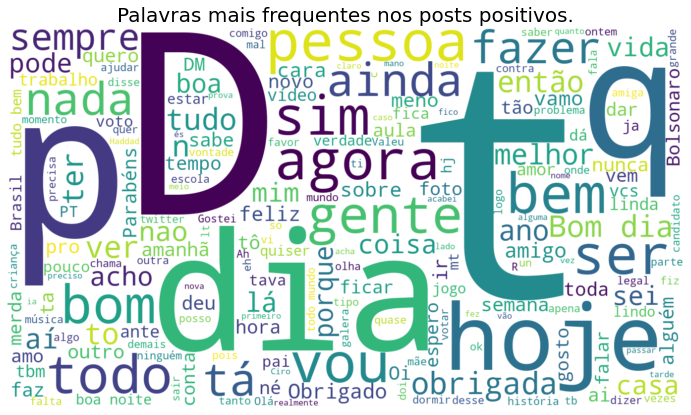

In [42]:

plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = nltk_stopwords_portuguese, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(train_ds[train_ds.sentiment	=='Positive'].tweet_text))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes nos posts positivos.',fontsize=20)
plt.show()

## Fase 3 - Modelos de linguagem e Representação Numerica

### WORD2VEC

In [127]:
num_features = 300 
min_word_count = 40 
num_workers = 4     
context = 10        
downsampling = 1e-3

# Initializing the train model
from gensim.models import word2vec

model_word2vec = word2vec.Word2Vec(X_train,\
                          workers=num_workers,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)


model_word2vec.init_sims(replace=True)


<ipython-input-127-804855071e82>:17: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model_word2vec.init_sims(replace=True)


In [128]:
## Analisar as semelhança entre as palavras

model_word2vec.wv.most_similar("homem")

[('mulher', 0.765924334526062),
 ('menino', 0.6830711364746094),
 ('marido', 0.6645025014877319),
 ('filho', 0.649709939956665),
 ('jornalista', 0.6024214625358582),
 ('ex', 0.595616340637207),
 ('gay', 0.5939220190048218),
 ('filha', 0.5903226733207703),
 ('morte', 0.5887876749038696),
 ('preso', 0.5808597207069397)]

## FASE 4 - Preparar e treinar o modelos

Carregar as bibibliotecas necessarias;

In [4]:
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation,Dropout, Flatten, Dense, Input
from tensorflow.keras.models import load_model, Model, Sequential


import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.tokenize.treebank import TreebankWordDetokenizer
import numpy as np


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



## LTSM

In [5]:

labels_train = np.array(y_train)
y = []
for i in range(len(labels_train)):
    if labels_train[i] == 'Neutral':
        y.append(0)
    if labels_train[i] == 'Negative':
        y.append(1)
    if labels_train[i] == 'Positive':
        y.append(2)
y = np.array(y)
labels_train = tf.keras.utils.to_categorical(y, 3, dtype="float32")

## Dados teste



labels_test = np.array(y_test)
y = []
for i in range(len(labels_test)):
    if labels_test[i] == 'Neutral':
        y.append(0)
    if labels_test[i] == 'Negative':
        y.append(1)
    if labels_test[i] == 'Positive':
        y.append(2)
y = np.array(y)
labels_test = tf.keras.utils.to_categorical(y, 3, dtype="float32")


NameError: name 'y_train' is not defined

In [6]:
print(labels_test)

NameError: name 'labels_test' is not defined

In [7]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [133]:
data_train = []
data_test = []
for i in range(len(X_train_tokens)):
    data_train.append(detokenize(X_train_tokens[i]))

##dados teste
for i in range(len(X_test_tokens)):
    data_test.append(detokenize(X_test_tokens[i]))

print(data_test[:5])

['obrig', 'pa put par', 'qu descont conf link compartilh nao encontr ofert cupom procur nao preocup cri pagin ofert cupom atual di', 'vou peg ajud gal am but', 'estav cas ze morr son cheg cas fic son']


In [134]:
data_test = np.array(data_test)
data_train = np.array(data_train)

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_train)
sequences = tokenizer.texts_to_sequences(data_train)
tweets_train = pad_sequences(sequences, maxlen=max_len)
print(tweets_train)


tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_test)
sequences = tokenizer.texts_to_sequences(data_test)
tweets_test = pad_sequences(sequences, maxlen=max_len)
print(tweets_test)





##----------------


[[   0    0    0 ...  124  139 3611]
 [   0    0    0 ...  162   52 1845]
 [   0    0    0 ...  280 1015  232]
 ...
 [   0    0    0 ...  457  598    3]
 [   0    0    0 ...  361  182  357]
 [   0    0    0 ... 2977 1330 1968]]
[[   0    0    0 ...    0    0   25]
 [   0    0    0 ... 1697  639  166]
 [   0    0    0 ... 1383  894 1384]
 ...
 [   0    0    0 ...  412  788   83]
 [   0    0    0 ...   22   21  111]
 [   0    0    0 ...   61 1146  335]]


#### Definir o modelo



NOTA: EM BAIXO É  POSSIVEL CARREGAR O MODELO PREVIAMENTE TREINADO

In [59]:

max_words = 5000
max_len = 200

from keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=5)
    

### Treinar o modelo

In [60]:
history = model.fit(tweets_train, labels_train, epochs=100,validation_data=(tweets_test, labels_test), callbacks = [es], steps_per_epoch = 250)

Epoch 1/100
250/250 [==============================] - 15s 46ms/step - loss: 0.9283 - accuracy: 0.5418 - val_loss: 1.1759 - val_accuracy: 0.4249
Epoch 2/100
250/250 [==============================] - 10s 41ms/step - loss: 0.6119 - accuracy: 0.7242 - val_loss: 1.3293 - val_accuracy: 0.4205
Epoch 3/100
250/250 [==============================] - 10s 40ms/step - loss: 0.5608 - accuracy: 0.7527 - val_loss: 1.3751 - val_accuracy: 0.4023
Epoch 4/100
250/250 [==============================] - 10s 41ms/step - loss: 0.5388 - accuracy: 0.7649 - val_loss: 1.3987 - val_accuracy: 0.4023
Epoch 5/100
250/250 [==============================] - 10s 41ms/step - loss: 0.5278 - accuracy: 0.7693 - val_loss: 1.4443 - val_accuracy: 0.3975
Epoch 6/100
250/250 [==============================] - 10s 41ms/step - loss: 0.5227 - accuracy: 0.7710 - val_loss: 1.4116 - val_accuracy: 0.3961


### Validação do modelo


Os graficos abaixo mostram a evolução da acuraccy e loss ao longo dos vários epochs.

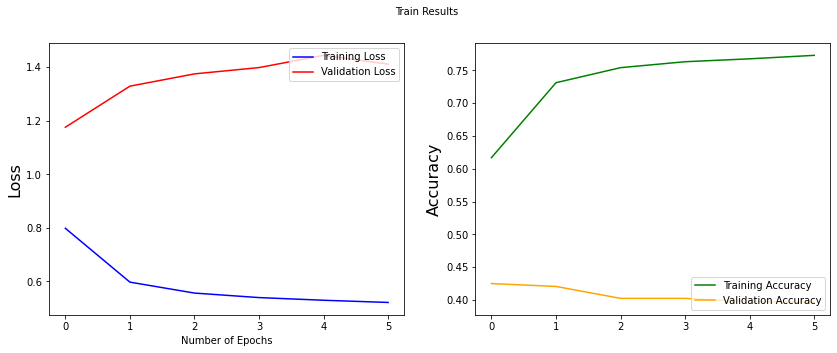

In [61]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.suptitle('Train Results', fontsize=10)
plt.xlabel("Number of Epochs")
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], color='green', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


##### Vamos agora testar o modelo, 

In [8]:
##Testar

sentiment = ['Neutral','Negative','Positive']

sequence = tokenizer.texts_to_sequences(["Os portugueses estão muito felizes com as decisões tomadas pelo Sr. Primeir ministro " ])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

NameError: name 'tokenizer' is not defined

In [63]:
##Testar

sentiment = ['Neutral','Negative','Positive']

sequence = tokenizer.texts_to_sequences(["População de braga zangada com as más atitudes dos Bracarences." ])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [64]:
##Testar

sentiment = ['Neutral','Negative','Positive']

sequence = tokenizer.texts_to_sequences(["Vandalização do jardim de Santa Barbara.  Bracarences revoltados " ])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [66]:

sentiment = ['Neutral','Negative','Positive']

sequence = tokenizer.texts_to_sequences(["O ordenado minimo sobe para dois mil euros. Portugueses mostram-se contentes" ])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [67]:

sentiment = ['Neutral','Negative','Positive']

sequence = tokenizer.texts_to_sequences(["Cristina ferreira volta a perder as audiencias. Tvi em desespero total " ])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Neutral'

In [68]:

sentiment = ['Neutral','Negative','Positive']

sequence = tokenizer.texts_to_sequences(["Cristina ferreira de ferias no dubai, gera revolta e criticas nas redes sociais " ])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Neutral'

In [138]:

sentiment = ['Neutral','Negative','Positive']

sequence = tokenizer.texts_to_sequences(["Racismo em braga"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Neutral'

##### Para guardar o modelo

In [74]:
!pip install pyyaml h5py

In [84]:
# Save the entire model as a SavedModel.
!mkdir -p Models
model.save('Models/ltsm') 

A subdirectory or file -p already exists.
Error occurred while processing: -p.


INFO:tensorflow:Assets written to: Models/ltsm\assets


INFO:tensorflow:Assets written to: Models/ltsm\assets


In [ ]:
# my_model directory
!ls Models

# Contains an assets folder, saved_model.pb, and variables folder.
!ls Models/ltsm

In [2]:
model = tf.keras.models.load_model('Models/ltsm')

# Check its architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 40)           200000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 123       
Total params: 209,883
Trainable params: 209,883
Non-trainable params: 0
_________________________________________________________________


In [3]:

sentiment = ['Neutral','Negative','Positive']

sequence = tokenizer.texts_to_sequences(["Racismo em braga"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

NameError: name 'tokenizer' is not defined

## CNN

In [ ]:
### MODELO:

## É preciso perceber como integrar a associação do word2vec (feita acima) nestas redes


conv_blocks = []

cnn = Sequential()

cnn.add(Conv1D(filters=10,
                         kernel_size=3,
                         padding="valid",
                         activation="relu",
                         strides=1))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())

cnn.add(Concatenate()) 
cnn.add(Dropout(0.3))

cnn.add(Dense(50, activation="relu"))

cnn.add(Dense(1, activation="sigmoid"))

cnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])



# Train the model
cnn.fit(X_train_tokens, y_train, batch_size=63, epochs=10, verbose=2)

ValueError: ignored

### Análise dos resultados

In [ ]:
def _get_accuracy(matrix):
    acc = 0
    n = 0
    total = 0
    
    for i in range(0, len(matrix)):
        for j in range(0, len(matrix)):
            if(i == j): 
                n += matrix[i,j]
            
            total += matrix[i,j]
            
    acc = n / total
    return acc

In [ ]:
matrix = metrics.confusion_matrix(y_test, predictions)
acc = _get_accuracy(matrix)
print(acc)

NameError: ignored

In [ ]:
y_pred=model.predict(X_test_tfidf)
plot_cm(y_test, y_pred)

In [ ]:
# performance analysis of the results
print(metrics.classification_report(y_test, predictions, target_names=model.classes_))

## Fase 5 - Aplicar o modelo às noticias;

In [149]:
def makePrediction(corpus, regex_pattern1=regex_pattern1, regex_pattern2=regex_pattern2,
                   std_list = std_list, nltk_stopwords=nltk_stopwords_portuguese):
    X_new= remove_url(corpus)
    X_new= remove_regex(X_new,regex_pattern1)
    X_new= remove_regex(X_new,regex_pattern2)
 
    X_new_tokens= tokenize_text(X_new)
    
    X_new_tokens= apply_standardization(X_new_tokens, std_list)
    X_new_tokens = remove_stopwords(X_new_tokens, nltk_stopwords)
    X_new = detokenize(X_new_tokens)
    X_new_vect = vectorizer.transform(X_new)
    X_new_tfidf = tfidf_transformer.transform(X_new_vect)
    X_new_tfidf = tfidf_transformer.transform(X_new_vect)
    standalone_predictions = best.predict(X_new_tfidf)
    return standalone_predictions

In [150]:
new_corpus = ["triste"]

In [151]:
#standalone_predictions = model.predict(X_new_tfidf)
#standalone_predictions
s=makePrediction(new_corpus)
s

TypeError: sequence item 0: expected str instance, list found